In [1]:
import tkinter as tk
from tkinter import scrolledtext
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import networkx as nx

nlp = spacy.load("en_core_web_sm")


In [2]:
together_words = {"and", "both", "along with", "as well as", "in conjunction with", "together with"}
individual_words = {"or", "either", "one of", "neither", "nor", "any of", "each of"}

In [3]:
#Entities
class Preposition:
    def __init__(self, name):
        self.name = name

    def __str__(self):
        return f"({self.name})"
    
    
class Verb:
    def __init__(self, name):
        self.name = name
    def __str__(self):
        return f"{self.name}"

class Noun:
    def __init__(self, name, preposition=None):
        self.name = name
        self.preposition = preposition if isinstance(preposition, list) else [preposition]
    
    def __str__(self):
        if self.preposition:
            p = ', '.join(str(p) for p in self.preposition)
            return f"{self.name}, {p}"
        else:
            return f"{self.name}"

    
class Task:
    def __init__(self, verbs, nouns):
        self.verbs = verbs if isinstance(verbs, list) else [verbs] 
        self.nouns = nouns if isinstance(nouns, list) else [nouns]
    def __str__(self):
        verb_str = ', '.join(str(verbs) for verbs in self.verbs)
        nouns_str = ', '.join(str(noun) for noun in self.nouns)
        return f"Task(Verbs: [{verb_str}], Nouns: [{nouns_str}])"
    
    def get_all_actors(self):
        actors = []
        for noun in self.nouns:
            actors.extend(noun.name)  
        return actors


preposition1 = Preposition("on")
noun1 = Noun("table", preposition1)
noun2 = Noun("chair")

# Create a list of verbs
verbs = Task(["places", "moves"], [noun1, noun2])

# Print out the verb and its related nouns and prepositions
print(verbs)  # Output: Verb(places, moves, Noun(table, floor, Preposition(on)), Noun(chair))


Task(Verbs: [places, moves], Nouns: [table, (on), chair, None])


In [4]:
def analyse_tree(doc):

    all_tasks = []

    def add_actors(subj):
        prepositions = []
        collect_prepositions(subj, prepositions)
        actor = Noun(subj.text, prepositions)
        return actor
    
    def add_task(verbs, actors):
        task = Task(verbs, actors)
        return task
    
    def add_verb(verb):
        verb1 = Verb(verb.text)
        return verb1

    def collect_subj_conjuncts(subj, actors):
        for child in subj.children:
            if child.dep_ == "conj":
                actor = add_actors(child)
                actors.append(actor)
                collect_subj_conjuncts(child, actors)
    
    def collect_prepositions(subj, prepositions):
        for child in subj.children:
            if child.dep_ == "cc":
                preposition = Preposition(child.text)
                prepositions.append(preposition)


    def collect_conjuncts(verb, root_subject, verb_data):
        for child in verb.children:
            if child.dep_ == "conj" and child.pos_ == "VERB":
                conj_nsubj = []

                # Check if the conjunct verb has its own subject
                for grandchild in child.children:
                    if grandchild.dep_ == "nsubj":
                        actor = add_actors(grandchild)
                        conj_nsubj.append(actor)
                        collect_subj_conjuncts(grandchild, conj_nsubj)

                # If no subject for the conjunct verb, add it to the root's verb_data
                if not conj_nsubj:
                    verb = add_verb(child)
                    verb_data.append(verb) 
                else:
                    verb = add_verb(child)
                    task = add_task(verb, conj_nsubj)
                    all_tasks.append(task)

                collect_conjuncts(child, root_subject, verb_data)

    for token in doc:
        if token.dep_ == "ROOT":
            verb = add_verb(token)
            verb_data = [verb]  # Start with the root verb
            actors_list = []

            for child in token.children:
                if child.dep_ == "nsubj":
                    actor = add_actors(child)
                    actors_list.append(actor)
                    collect_subj_conjuncts(child, actors_list)

            task = add_task(verb_data, actors_list)
            all_tasks.append(task)
            collect_conjuncts(token, actors_list, verb_data)

    return all_tasks


In [5]:
def is_or_exist(actors):
    for actor in actors:
        for p in actor.preposition:
            if p.name == "or":
                return True
    return False

def is_this_or(actor):
    for p in actor.preposition:
        if p.name == "or":
            return True
    return False

def is_and_exist(actors):
    for actor in actors:
        for p in actor.preposition:
            if p.name == "and":
                return True
    return False

def print_actors_names(actors):
    s = ""
    for a in actors:
        s+= a.name+("_")
    return s

#rules for created dictionary
def get_parallel_tasks(doc):
    order_cnt = 0
    actors_actions = {}
    all_tasks = analyse_tree(doc)
    print(all_tasks)

    for task in all_tasks:
        if len(task.nouns) > 1:
            for verb in task.verbs:

                #task choice
                if (is_or_exist(task.nouns)): #gather actors groups if there is OR 
                    actors_before = []
                    groups = ""
                    for actor in task.nouns:
                        if actor.name not in actors_actions:
                            actors_actions[actor.name] = []
                            actors_before.append(actor)
                        if (is_this_or(actor)):
                            if (is_and_exist(actors_before)):
                                names_str = print_actors_names(actors_before)
                                for a in actors_before:
                                    actors_actions[a.name].append("OR_" + names_str + str(order_cnt))
                                    actors_actions[a.name].append(verb.name)
                            else:
                                for a in actors_before:
                                    actors_actions[a.name].append("OR_" + a.name + "_" + str(order_cnt))
                                    actors_actions[a.name].append(verb.name) 
                            actors_before = []                           
                    names_str = print_actors_names(actors_before)
                    for a in actors_before:
                        actors_actions[a.name].append("OR_" + names_str + str(order_cnt))
                        actors_actions[a.name].append(verb.name)
                    print(groups)
                    order_cnt+=1
                    
                #no choice
                else:
                    for actor in task.nouns:                                               
                        if actor.name not in actors_actions:
                            actors_actions[actor.name] = []
                        names_str = print_actors_names(task.nouns)
                        actors_actions[actor.name].append("BARRIER_" + names_str + str(order_cnt))
                        actors_actions[actor.name].append(verb.name)
                        actors_actions[actor.name].append("SINC_"+ names_str + str(order_cnt))
                    order_cnt+=1
        else:
            actor = task.nouns[0]
            if actor.name not in actors_actions:
                    actors_actions[actor.name] = []
            for verb in task.verbs:
                    actors_actions[actor.name].append(verb.name)
    print(actors_actions)
    return actors_actions

input_text ="Robot A, Robot B and Robot C walk."
doc = nlp(input_text)
get_parallel_tasks(doc)



{'A': ['BARRIER_A_B_C_0', 'walk', 'SINC_A_B_C_0'], 'B': ['BARRIER_A_B_C_0', 'walk', 'SINC_A_B_C_0'], 'C': ['BARRIER_A_B_C_0', 'walk', 'SINC_A_B_C_0']}


{'A': ['BARRIER_A_B_C_0', 'walk', 'SINC_A_B_C_0'],
 'B': ['BARRIER_A_B_C_0', 'walk', 'SINC_A_B_C_0'],
 'C': ['BARRIER_A_B_C_0', 'walk', 'SINC_A_B_C_0']}

In [15]:
def draw_petri_net(petri_net, pos, actor_labels):
    import matplotlib.pyplot as plt

    # Draw the Petri Net
    node_shapes = nx.get_node_attributes(petri_net, 'shape')
    node_colors = nx.get_node_attributes(petri_net, 'color')
    node_labels = nx.get_node_attributes(petri_net, 'label')

    for shape in set(node_shapes.values()):
        nodes = [node for node, attr in node_shapes.items() if attr == shape]
        nx.draw_networkx_nodes(
            petri_net, pos,
            nodelist=nodes,
            node_shape='o' if shape == 'circle' else 's',  # 'o' = circle, 's' = square
            node_color=[node_colors[node] for node in nodes]
        )

    nx.draw_networkx_edges(petri_net, pos, arrows=True)
    nx.draw_networkx_labels(petri_net, pos, labels=node_labels)

    for actor, actor_pos in actor_labels.items():
        # Actor labels are not positioned meaningfully here due to spring layout
        plt.text(-1, -1, actor, fontsize=12, fontweight='bold', ha='right', va='center', color='black')

    plt.axis('off')
    plt.show()

In [ ]:
def prepare_petri_net(data):
    import networkx as nx
    import matplotlib.pyplot as plt

    petri_net = nx.DiGraph()
    actor_labels = {}

    start_state = "START"
    petri_net.add_node(start_state, shape="circle", color="lightblue", label="START")

    end_state = "END"
    petri_net.add_node(end_state, shape="circle", color="lightblue", label="END")

    for key, sequence in data.items():
        # Connect the starting state to the first state of each actor
        first_state = f"{key}_{sequence[0]}_0"
        petri_net.add_node(first_state, shape="circle", color="lightblue", label=sequence[0])
        petri_net.add_edge(start_state, first_state)  # Connect START to the first state

        for i in range(len(sequence) - 1):
            # Create unique state names for each occurrence
            source_state = f"{key}_{sequence[i]}_{i}"
            target_state = f"{key}_{sequence[i + 1]}_{i + 1}"

            petri_net.add_node(source_state, shape="circle", color="lightblue", label=sequence[i])
            petri_net.add_node(target_state, shape="circle", color="lightblue", label=sequence[i + 1])

            # Add a unique transition for this connection
            transition_name = f"{key}_T{i}"
            petri_net.add_node(transition_name, shape="rectangle", color="lightgreen", label=f"T{i}")

            # Connect source state -> transition -> target state
            petri_net.add_edge(source_state, transition_name)
            petri_net.add_edge(transition_name, target_state)

        # Connect the last state of each actor to the ending state
        last_state = f"{key}_{sequence[-1]}_{len(sequence) - 1}"
        petri_net.add_edge(last_state, end_state)

        # Add actor labels (positioning not relevant with spring layout)
        actor_labels[key] = None

    # Calculate positions using spring layout
    pos = nx.spring_layout(petri_net)

    # Draw the Petri Net
    draw_petri_net(petri_net, pos, actor_labels)




{'A': ['OR_A_B_0', 'walk'], 'B': ['OR_A_B_0', 'walk'], 'C': ['OR_C_0', 'walk']}


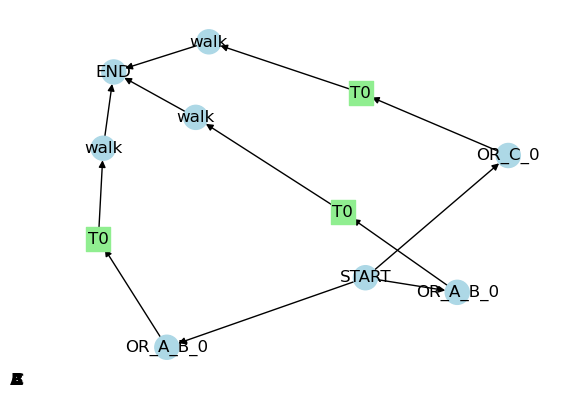

In [17]:


input_text = "Robot A and Robot B, or Robot A and Robot C walk."
doc = nlp(input_text)
a = get_parallel_tasks(doc)
prepare_petri_net(a)

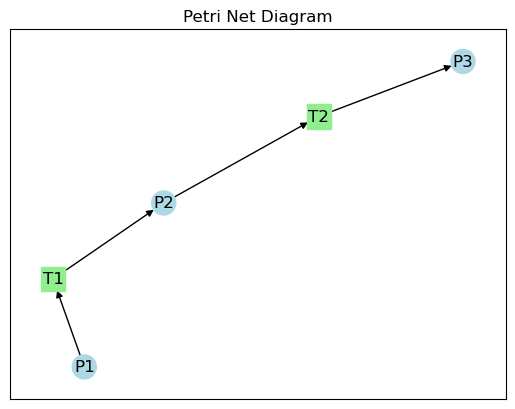

In [9]:
petri_net = nx.DiGraph()

places = ['P1', 'P2', 'P3']
for place in places:
    petri_net.add_node(place, shape='circle', color='lightblue')

transitions = ['T1', 'T2']
for transition in transitions:
    petri_net.add_node(transition, shape='rectangle', color='lightgreen')

edges = [
    ('P1', 'T1'), 
    ('T1', 'P2'), 
    ('P2', 'T2'),  
    ('T2', 'P3')  
]
    
petri_net.add_edges_from(edges)

pos = nx.spring_layout(petri_net) 
node_shapes = nx.get_node_attributes(petri_net, 'shape')
node_colors = nx.get_node_attributes(petri_net, 'color')

for shape in set(node_shapes.values()):
    nodes = [node for node, attr in node_shapes.items() if attr == shape]
    nx.draw_networkx_nodes(
        petri_net, pos,
        nodelist=nodes,
        node_shape='o' if shape == 'circle' else 's', 
        node_color=[node_colors[node] for node in nodes]
    )

# Draw edges and labels
nx.draw_networkx_edges(petri_net, pos, arrows=True)
nx.draw_networkx_labels(petri_net, pos)

plt.title("Petri Net Diagram")
plt.show()


In [10]:
# Test
#OR cases

#successful
#input_text = "Mary and Ben or Mark and John walk."
#input_text = "Mary, Ben or Mark and John walk."
#input_text = "Mary, Ben or Mark walk."
#input_text = "Robot A and Robot B, or Robot A and Robot C walk."


doc = nlp(input_text)
get_parallel_tasks(doc)


{'A': ['OR_A_B_0', 'walk'], 'B': ['OR_A_B_0', 'walk'], 'C': ['OR_C_0', 'walk']}


{'A': ['OR_A_B_0', 'walk'], 'B': ['OR_A_B_0', 'walk'], 'C': ['OR_C_0', 'walk']}

In [11]:
# Test

#input_text = "Robot A and Robot B take the pot. Robot C takes the spoon. Robots A and Robot C help each other"
#input_text = "Robot A takes the pan, Robot B takes the pencil."
#input_text = "Robot A takes the pan and drops it. "
#input_text = "Robot A, Robot B and Robot C takes the pan, Robot B takes the pencil"
#input_text = "Robot A and Robot B take the pot. Robot C takes the spoon. Robot A and Robot C work together and Robot B is cleaning"

#WEIRD BEHAVIOUR in spacy
#input_text = "Robots A and Robot C help each other and Robot B is cleaning"
#input_text = "Robots A and Robot C help each other, Robot B cleans"

input_text = "Some of the robots picks up the box"

doc = nlp(input_text)
all_tasks = analyse_tree(doc)
for i in all_tasks:
    print(i)

#options={"compact": True, "distance":60}
spacy.displacy.serve(doc, style="dep", auto_select_port=True)
#print_tasks(doc)


Task(Verbs: [picks], Nouns: [Some])


/opt/anaconda3/lib/python3.11/site-packages/spacy/util.py:1835: UserWarning: [W124] 0.0.0.0:5000 is already in use, using the nearest available port 5001 as an alternative.
  warnings.warn(Warnings.W124.format(host=host, port=start, serve_port=port))
/opt/anaconda3/lib/python3.11/site-packages/spacy/displacy/__init__.py:106: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5001 ...

Shutting down server on port 5001.


In [ ]:
def display_input():
    input_text = entry.get()
    label.config(text=input_text)
    
    doc = nlp(input_text)
    result_text.delete(1.0, tk.END)
    
   
    subjects_info = analyse_tree(doc)
    # Insert the subjects and conjuncts information into the text area
    result_text.insert(tk.END, subjects_info)

In [ ]:
# Create the main window
root = tk.Tk()
label = tk.Label(root, text="Your input will appear here", font=('Arial', 14))
label.pack(pady=10)
entry = tk.Entry(root, font=('Arial', 14))
entry.pack(pady=10)
button = tk.Button(root, text="Analyze", command=display_input, font=('Arial', 14))
button.pack(pady=10)
result_text = scrolledtext.ScrolledText(root, wrap=tk.WORD, width=60, height=15, font=('Arial', 12))
result_text.pack(pady=10)

root.mainloop()

# Part 1: Foundations of infovis 🚀

Let's get started with exploring some datasets with basic chart types!

👉 This part has two TODOs (1.1, 1.2).

To get started, here are the references for the data we use for some examples: 

- "Global air quality data provided by the World Health Organization" | [Source: WHO](https://www.who.int/data/gho/data/themes/air-pollution/who-air-quality-database)

- "WHO regional groupings" by income | [Source: WHO](https://cdn.who.int/media/docs/default-source/air-pollution-documents/air-quality-and-health/country-groupings-database-2022.pdf)

Let's load the dataset and have a first look: